# Анализ поведения пользователей в мобильном приложении

## Описание и цели проекта

**Цель** - исследование поведения пользователей для увеличения вовлеченности.

**Задача** - проанализировать поведение пользователей, которое приводит к целевому событию — просмотра контактов, а также оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.

**Описание данных**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений. В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в `mobile_sources.csv`:
* userId — идентификатор пользователя;
* source — источник, с которого пользователь установил приложение.

Колонки в `mobile_dataset.csv`:
* event.time — время совершения;
* user.id — идентификатор пользователя;
* event.name — действие пользователя.

Виды действий:
* advert_open — открыл карточки объявления;
* photos_show — просмотрел фотографий в объявлении;
* tips_show — увидел рекомендованные объявления;
* tips_click — кликнул по рекомендованному объявлению;
* contacts_show и show_contacts — посмотрел номер телефона;
* contacts_call — позвонил по номеру из объявления;
* map — открыл карту объявлений;
* search_1 — search_7 — разные действия, связанные с поиском по сайту;
* favorites_add — добавил объявление в избранное.

## Загрузка и изучение данных

Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

Прочитаем csv-файлы:

In [2]:
dataset = pd.read_csv('mobile_dataset.csv')
sources = pd.read_csv('mobile_sourсes.csv')

Выведем первые 5 строчек датафреймов:

In [3]:
display(dataset.head())
display(sources.head())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Выведем основную информацию о датафреймах:

In [4]:
display(dataset.info())
display(sources.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

**Вывод:** датафреймы нуждаются в предобработке, а именно необходимо привести названия столбцов к корректному виду, а также исправить типы данных. Датафреймы полные, количество Non-Null строк во всех столбцах соотвествует размеру датафреймов.

## Предобработка данных

Откорректируем названия столбцов:

In [5]:
dataset = dataset.rename(
    columns={
        'event.time': 'event_time',
        'event.name': 'event_name',
        'user.id': 'user_id'
    }
)
sources = sources.rename(
    columns={
        'userId': 'user_id'
    }
)

display(dataset.head())
display(sources.head())

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Приведем тип данных столбца `event_time` к datetime и выполним проверку:

In [6]:
dataset['event_time'] = pd.to_datetime(dataset['event_time']).dt.round('s')

display(dataset.info())
display(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


None

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Проверим датафреймы на наличие пропусков:

In [7]:
display(dataset.isna().sum())
display(sources.isna().sum())

,0
event_time,0
event_name,0
user_id,0


,0
user_id,0
source,0


Проверим датафреймы на наличие явных дубликатов:

In [8]:
display(dataset.duplicated().sum())
display(sources.duplicated().sum())

1118

0

Найдем долю дубликатов в датафрейме `dataset` в процентах:

In [9]:
dub_ratio = ((dataset.duplicated().sum() / len(dataset['user_id'])) * 100).round(2)
display(dub_ratio)

1.51

Так как доля дубликатов в датафрейме `dataset` составляет меньше 5% (1.51%), то можно избравиться от этих дубликатов, в дальнейшем на анализе это не скажется.

Удалим явные дубликаты из датафрейма dataset и выполним проверку:

In [10]:
dataset = (
    dataset
    .drop_duplicates()
    .reset_index(drop=True)
)

display(dataset.duplicated().sum())
print()
display(dataset.info())

0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73079 entries, 0 to 73078
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  73079 non-null  datetime64[ns]
 1   event_name  73079 non-null  object        
 2   user_id     73079 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


None

Найдем явные дубликаты по двум столбцам: `event_time` и `user_id` - если такие дубликаты есть, то это значит, что в одно время один и тот же пользователь совершил разные действия

In [11]:
display(dataset.duplicated(subset=['event_time', 'user_id']).sum())

139

Удалим явные дубликаты из датафрейма `dataset` по двум столбцам: `event_time` и `user_id` и выполним проверку:

In [12]:
dataset = (
    dataset
    .drop_duplicates(subset=['event_time', 'user_id'])
    .reset_index(drop=True)
)

display(dataset.duplicated(subset=['event_time', 'user_id']).sum())
print()
display(dataset.info())

0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72940 entries, 0 to 72939
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  72940 non-null  datetime64[ns]
 1   event_name  72940 non-null  object        
 2   user_id     72940 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


None

Проверим столбец `event_name` в датафрейме `dataset` на наличие неявных дубликатов:

In [13]:
display(dataset['event_name'].unique())

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

Заменим неявный дубликат `show_contacts` на `contacts_show`:

In [14]:
dataset['event_name'] = dataset['event_name'].replace('show_contacts', 'contacts_show')

Выполним проверку:

In [15]:
# проверим, что значения успешно заменились
display(dataset['event_name'].unique())
print()
# проверим, что число значений в столбце не изменилось
display(dataset.info())

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72940 entries, 0 to 72939
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  72940 non-null  datetime64[ns]
 1   event_name  72940 non-null  object        
 2   user_id     72940 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


None

Объединим все типы поиска `search_1`-`search_7` в одно действие `search`:

In [16]:
dataset['event_name'] = (
    dataset['event_name']
    .replace(['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7'], 'search')
)

display(dataset['event_name'].unique())

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

Проверим столбец `source` в датафрейме `sources` на наличие неявных дубликатов:

In [17]:
sources['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

Объединим датафреймы:

In [18]:
df = (
    dataset
    .merge(sources, on='user_id')
    .sort_values(['user_id', 'event_time'])
    .reset_index(drop=True)
)

display(df)

,event_time,event_name,user_id,source
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other
...,...,...,...,...
72935,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
72936,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
72937,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google
72938,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google


Тайм-аут сессии, согласно Яндекс Метрике по умолчанию равняется 30 минутам (https://yandex.ru/support/metrica/general/glossary.html).

Это же время можно найти и в других источниках (https://docs.tracker.my.com/reports/selector-set/sessions?lang=ru).

Таким образом, в качестве тайм-аута сессии примем 30 минут.

Выделим тайм-аут сессий:

In [19]:
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1
display(df)

,event_time,event_name,user_id,source,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
...,...,...,...,...,...
72935,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72936,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72937,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72938,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368


**Вывод:** в ходе этапа предобработки данных названия столбцов были приведены к корректному виду, была выполнена проверка на пропуски и дубликаты. Количество дубликатов не превысило 5%, поэтому они были удалены. Также был добавлен расчет шага в сессии, а сами сессии были выделены с помощью тайм-аута сессии.

## Исследовательский анализ данных

Убедимся, что данные в датафрейме соответствуют описанию данных - первые действия в приложении после 7 октября 2019 года:

In [20]:
df['event_time'].min()

Timestamp('2019-10-07 00:00:00')

Также найдем время последнего события:

In [21]:
df['event_time'].max()

Timestamp('2019-11-03 23:58:13')

### Найдем популярные сценарии

Определим паттерны поведения пользователей в приложении - какой путь совершает пользователь, чтобы просмотреть контакты.

Избавимся от повторяющихся значений:

In [22]:
df_new = df.drop_duplicates(subset=['event_name', 'session_id'], keep='first')

Отсортируем по id сессии и времени:

In [23]:
df_new = df_new.sort_values(by=['session_id', 'event_time'])

Добавим новые столбцы для расчета шага и следующего действия:

In [24]:
df_new['step'] = df_new.groupby('session_id').cumcount() + 1
df_new['target'] = df_new.groupby('session_id')['event_name'].shift(-1)

display(df_new)

,event_time,event_name,user_id,source,session_id,step,target
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1,1,NaN
9,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,1,tips_show
11,2019-10-09 18:40:29,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,2,NaN
13,2019-10-21 19:52:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,3,1,map
15,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,3,2,NaN
...,...,...,...,...,...,...,...
72908,2019-11-02 19:26:08,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10366,2,NaN
72911,2019-11-03 14:32:56,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10367,1,contacts_show
72912,2019-11-03 14:33:48,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10367,2,NaN
72926,2019-11-03 15:36:01,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368,1,contacts_show


Исключим действие `tips_show`, так как это автоматическое действие:

In [25]:
df_new = df_new[df_new['event_name'] != 'tips_show'].reset_index(drop=True)

display(df_new)

,event_time,event_name,user_id,source,session_id,step,target
0,2019-10-09 18:33:56,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2,1,tips_show
1,2019-10-21 19:53:39,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,3,2,NaN
2,2019-10-22 11:18:15,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,4,1,tips_show
3,2019-10-19 21:34:34,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5,1,photos_show
4,2019-10-19 21:40:39,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5,2,NaN
...,...,...,...,...,...,...,...
11803,2019-10-30 00:15:43,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10361,1,tips_show
11804,2019-11-02 18:17:41,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10365,2,NaN
11805,2019-11-02 19:26:08,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10366,2,NaN
11806,2019-11-03 14:33:48,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10367,2,NaN


Получим сценарии для каждой сессии в одной ячейке:

In [26]:
df_grouped = df_new.groupby('session_id')['event_name'].apply(lambda x: ', '.join(x)).reset_index()

df_grouped.head(10)

,session_id,event_name
0,2,map
1,3,map
2,4,map
3,5,"search, photos_show"
4,6,"search, photos_show, favorites_add, contacts_s..."
5,7,"photos_show, advert_open"
6,8,"search, photos_show, contacts_show, contacts_c..."
7,9,"search, photos_show, contacts_show"
8,10,contacts_show
9,11,photos_show


Отфильтруем сценарии так, чтобы в каждом присутствовало целевое действие:

In [27]:
target = 'contacts_show'
df_target = df_grouped[df_grouped['event_name'].apply(lambda x: target in x)]

Добавим фильтр, отсеиващий `contacts_show` на первом шаге:

In [28]:
target_new = ', contacts_show'
df_target_new = df_target[df_target['event_name'].apply(lambda x: target_new in x)]

Посчитаем количество всех сценариев:

In [29]:
df_scenario = df_target['event_name'].value_counts()
df_scenario.head(10)

,count
event_name,
contacts_show,609
"map, contacts_show",150
"contacts_show, contacts_call",119
"search, contacts_show",100
"photos_show, contacts_show",85
"search, contacts_show, contacts_call",54
"search, photos_show, contacts_show",45
"contacts_show, photos_show",38
"contacts_show, tips_click",38


Найдем самые популярные сценарии:

In [30]:
df_scenario = df_target_new['event_name'].value_counts()

df_scenario.head(10)

,count
event_name,
"map, contacts_show",150
"search, contacts_show",100
"photos_show, contacts_show",85
"search, contacts_show, contacts_call",54
"search, photos_show, contacts_show",45
"photos_show, contacts_show, contacts_call",35
"map, advert_open, contacts_show",22
"tips_click, contacts_show",19
"advert_open, contacts_show",16


**Вывод:** в результате было выбрано два сценария, состоящие из трех действий, приводящих к contacts_show:

1. search, photos_show, contacts_show
2. map, advert_open, contacts_show

Данный выбор обусловлен тем, что в топ-10 популярных сценариев только эти два сценария имеют больше 2 шагов, а заканиваются сценарии целевым событием.

### Построим воронки

Визуализируем популярные сценарии, построив воронки.

Создадим функцию, рассчитывающую кол-во действий на каждом шаге для построения воронки:

In [31]:
def calculate(step_one, step_two, step_three):
    first_step_df = df_new[(df_new['event_name'] == step_one) & (df_new['step'] == 1)]
    first_step_count = first_step_df['event_name'].count()
    users_first_step = first_step_df['user_id'].unique()

    second_step_df = df_new[(df_new['user_id'].isin(users_first_step)) & (df_new['event_name'] == step_two) & (df_new['step'] == 2)]
    second_step_count = len(second_step_df)
    users_second_step = second_step_df['user_id'].unique()

    third_step_df = df_new[(df_new['user_id'].isin(users_second_step)) & (df_new['event_name'] == step_three) & (df_new['step'] == 3)]
    third_step_count = len(third_step_df)

    return first_step_count, second_step_count, third_step_count

In [32]:
first_step_count_one, second_step_count_one, third_step_count_one = calculate('search', 'photos_show', 'contacts_show')

Построим воронку по первому сценарию:

In [33]:
fig = go.Figure(
    go.Funnel(
        y=[
            'search',
            'photos_show',
            'contacts_show'
        ],
        x=[first_step_count_one, second_step_count_one, third_step_count_one],
    )
)

fig.update_layout(title_text='Воронка по сценарию search -> photos_show -> contacts_show', width=1000, height=600)
fig.show()

In [34]:
first_step_count_two, second_step_count_two, third_step_count_two = calculate('map', 'advert_open', 'contacts_show')

Построим воронку по первому сценарию:

In [35]:
fig = go.Figure(
    go.Funnel(
        y=[
            'map',
            'advert_open',
            'contacts_show'
        ],
        x=[first_step_count_two, second_step_count_two, third_step_count_two],
    )
)

fig.update_layout(title_text='Воронка по сценарию map -> advert_open -> contacts_show', width=1000, height=600)
fig.show()

**Вывод:** были построены воронки по двум сценариям. В обоих случаях конверсия в просмотр контаков в районе 2-3%.

### Оценим, какие действия чаще совершают пользователи - которые просматривают контакты или которые не просматривают контакты

Создадим датафрейм с пользователями, которые смотрели контакты:

In [36]:
filter_contacts_show = df[(df['event_name'] == 'contacts_show')]
users_contacts_show = filter_contacts_show['user_id'].unique()

df_contacts_show = df[df['user_id'].isin(users_contacts_show)]
df_contacts_show

,event_time,event_name,user_id,source,session_id
35,2019-10-19 21:34:34,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
36,2019-10-19 21:35:19,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
37,2019-10-19 21:36:44,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
38,2019-10-19 21:40:39,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
39,2019-10-19 21:42:14,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
...,...,...,...,...,...
72935,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72936,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72937,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72938,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368


Создадим датафрейм с пользователями, которые не смотрели контакты:

In [37]:
grouped = df.groupby('user_id')['event_name'].apply(lambda x: ', '.join(x)).reset_index()
mask = grouped['event_name'].transform(lambda x: x.str.contains('contacts_show'))

filter_no_contacts_show = grouped[mask == False]
users_no_contacts_show = filter_no_contacts_show['user_id'].unique()

df_no_contacts_show = df[df['user_id'].isin(users_no_contacts_show)]
df_no_contacts_show

,event_time,event_name,user_id,source,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
...,...,...,...,...,...
72614,2019-10-26 19:42:23,tips_show,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,yandex,10333
72615,2019-10-26 19:48:44,tips_show,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,yandex,10333
72616,2019-10-26 19:53:52,tips_show,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,yandex,10333
72623,2019-10-23 11:51:35,tips_show,ffcf50d9-293c-4254-8243-4890b030b238,google,10335


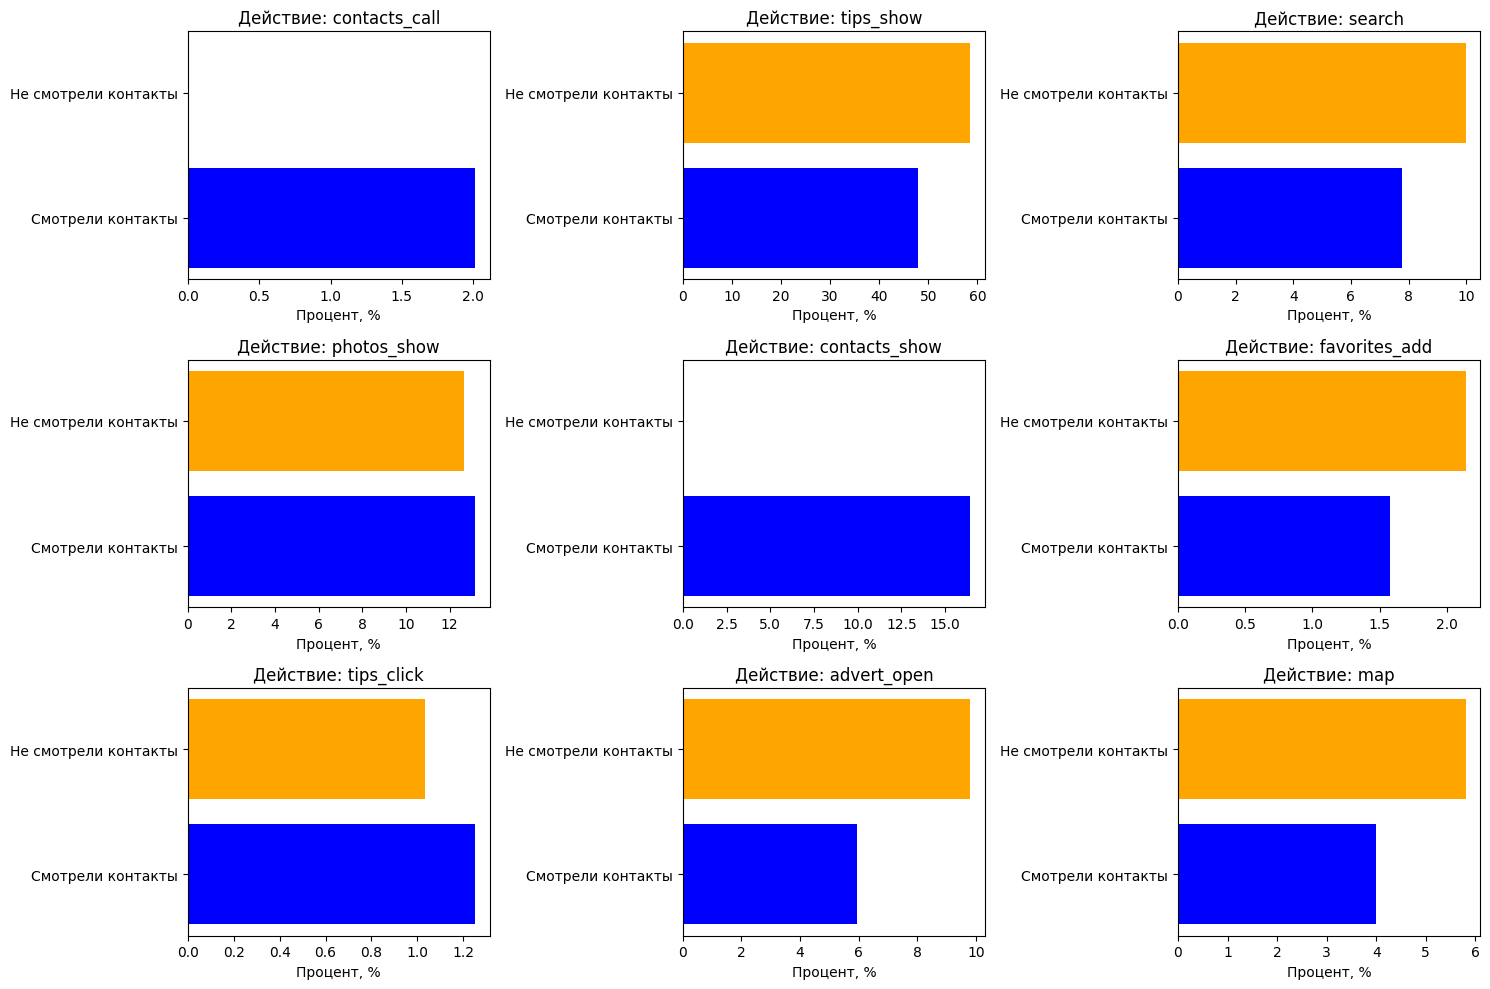

In [38]:
# найдем относительную частоту каждого действия в каждом датафрейме
relative_freq_contacts = df_contacts_show['event_name'].value_counts(normalize=True) * 100
relative_freq_no_contacts = df_no_contacts_show['event_name'].value_counts(normalize=True) * 100

# получим список уникальных действий в обоих датафреймах
actions = set(df_contacts_show['event_name']).union(df_no_contacts_show['event_name'])

colors = ['blue', 'orange']

# разместим все графики на одном
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# напишем цикл для построения графиков по всем действиям
counter = 0

for action in actions:
    ax = axes[counter // 3, counter % 3]
    freqs = [relative_freq_contacts.get(action, 0), relative_freq_no_contacts.get(action, 0)]

    ax.barh(['Смотрели контакты', 'Не смотрели контакты'], freqs, color=colors)
    ax.set_title(f'Действие: {action}')
    ax.set_xlabel('Процент, %')

    counter += 1

plt.tight_layout()
plt.show()

**Вывод:** были построены графики по каждому действию для двух групп, тех, кто смотрел контакты, и тех, кто не смотрел. Судя по полученным графикам, открывают объявления, добавляют в избранное, пользуются поиском, открывают карту объявлений, те пользователи, которые еще не просмотрели контакты. Это логично, ведь все эти действия отображают, что пользователь еще не определился с тем, что ему нужно, либо не готов купить в данный момент.

Что более интересно, так это то, что пользователи, смотревшие фото, чаще просматривают контакты. Возможно, стоит доработать этот функционал, чтобы усилить его влияние на конверсию в покупку товара.

## Проверка гипотез

### Гипотеза №1

Сформулируем гипотезы:

**Нулевая гипотеза:** конверсия в просмотры контактов между теми пользователями, которые совершили событие `tips_show` и событие `tips_click` и теми пользователями, которые совершили только событие `tips_show` равна.

**Альтернативная гипотеза:** конверсия в просмотры контактов между теми пользователями, которые совершили событие `tips_show` и событие `tips_click` и теми пользователями, которые совершили только событие `tips_show`, не равна.

Cоздадим датафрейм с пользователями, которые посмотрели и кликнули на рекомендацию:

In [39]:
filter_tips_show = df[(df['event_name'] == 'tips_show')]
filter_tips_click = df[(df['event_name'] == 'tips_click')]
users_tips_show = filter_tips_show['user_id'].unique()
users_tips_click = filter_tips_click['user_id'].unique()

df_tips_show_and_click = df[df['user_id'].isin(users_tips_show) & df['user_id'].isin(users_tips_click)]
df_tips_show_and_click

,event_time,event_name,user_id,source,session_id
282,2019-11-01 21:13:53,tips_show,01147bf8-cd48-49c0-a5af-3f6eb45f8262,google,42
283,2019-11-01 21:17:45,tips_show,01147bf8-cd48-49c0-a5af-3f6eb45f8262,google,42
284,2019-11-01 21:21:19,tips_show,01147bf8-cd48-49c0-a5af-3f6eb45f8262,google,42
285,2019-11-01 21:23:04,tips_show,01147bf8-cd48-49c0-a5af-3f6eb45f8262,google,42
286,2019-11-01 21:23:51,tips_show,01147bf8-cd48-49c0-a5af-3f6eb45f8262,google,42
...,...,...,...,...,...
72595,2019-10-30 19:46:32,tips_show,ff82c7c7-16d6-44b1-833b-a217747b0b02,yandex,10330
72596,2019-10-30 19:48:04,tips_show,ff82c7c7-16d6-44b1-833b-a217747b0b02,yandex,10330
72597,2019-10-30 19:50:56,tips_show,ff82c7c7-16d6-44b1-833b-a217747b0b02,yandex,10330
72598,2019-10-30 20:01:06,tips_show,ff82c7c7-16d6-44b1-833b-a217747b0b02,yandex,10330


Создадим датафрейм с пользователями, которые посмотрели рекомендацию, но не перешли по ней:

In [40]:
grouped = df.groupby('user_id')['event_name'].apply(lambda x: ', '.join(x)).reset_index()
mask = grouped['event_name'].transform(lambda x: x.str.contains('tips_click'))
filter_no_tips_click = grouped[mask == False]
users_no_tips_click = filter_no_tips_click['user_id'].unique()

df_only_tips_show = df[df['user_id'].isin(users_tips_show) & df['user_id'].isin(users_no_tips_click)]
df_only_tips_show

,event_time,event_name,user_id,source,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
...,...,...,...,...,...
72935,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72936,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72937,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72938,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368


In [41]:
# найдем количество действий 'contacts_show' у пользователей, кликнувших по рекомендованному объявлению
result_a_one = df_tips_show_and_click['event_name'].value_counts()
group_a_one = result_a_one['contacts_show']

# найдем сколько всего действий было совершено у пользователей, кликнувших по рекомендованному объявлению
group_a_total_one = len(df_tips_show_and_click)

In [42]:
# найдем количество действий 'contacts_show' у пользователей, которые не перешли по рекомендованному объявлению
result_b_one = df_only_tips_show['event_name'].value_counts()
group_b_one = result_b_one['contacts_show']

# найдем сколько всего действий было совершено у пользователей, которые не перешли по рекомендованному объявлению
group_b_total_one = len(df_only_tips_show)

In [43]:
# проверим гипотезу z-тестом для пропорций
alpha = 0.05

success_one = np.array([group_a_one, group_b_one])
total_one = np.array([group_a_total_one, group_b_total_one])

# используем функцию proportions_ztest из библиотеки statsmodels (по умолчанию alpha = 0.05)
stat, pval = proportions_ztest(success_one, total_one)
print('p-значение: {0:0.3f}'.format(pval))

if (pval < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение: 0.000
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** имеется статистически значимая разница между двумя выборками, что означает, что конверсии двух групп не равны между собой - конверсия у пользователей, которые совершили действие tips_click выше, а это значит, что рекомендательная система работает.

### Гипотеза №2

**Нулевая гипотеза:** конверсия в просмотры контактов между теми пользователями, которые совершили событие favorites_add и теми пользователями, которые не совершали, равна.

**Альтернативная гипотеза:** конверсия в просмотры контактов между теми пользователями, которые совершили событие favorites_add и теми пользователями, которые не совершали, не равна.

Создадим датафрейм с пользователями, которые добавили товар в избранное:

In [44]:
filter_favorite = df[(df['event_name'] == 'favorites_add')]
users_favorite = filter_favorite['user_id'].unique()

df_favorite = df[df['user_id'].isin(users_favorite)]
df_favorite

,event_time,event_name,user_id,source,session_id
35,2019-10-19 21:34:34,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
36,2019-10-19 21:35:19,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
37,2019-10-19 21:36:44,search,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
38,2019-10-19 21:40:39,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
39,2019-10-19 21:42:14,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,yandex,5
...,...,...,...,...,...
72097,2019-10-21 06:52:41,search,fd9b3591-9dd3-48c4-804d-cbcbb9a3b8da,other,10271
72098,2019-10-21 12:15:36,photos_show,fd9b3591-9dd3-48c4-804d-cbcbb9a3b8da,other,10272
72099,2019-10-21 12:17:30,search,fd9b3591-9dd3-48c4-804d-cbcbb9a3b8da,other,10272
72100,2019-10-21 12:17:35,search,fd9b3591-9dd3-48c4-804d-cbcbb9a3b8da,other,10272


Создадим датафрейм с пользователями, которые не добавляли товар в избранное:

In [45]:
grouped = df.groupby('user_id')['event_name'].apply(lambda x: ', '.join(x)).reset_index()
mask = grouped['event_name'].transform(lambda x: x.str.contains('favorites_add'))
filter_no_favorites = grouped[mask == False]
users_no_favorites = filter_no_favorites['user_id'].unique()

df_no_favorites = df[df['user_id'].isin(users_no_favorites)]
df_no_favorites

,event_time,event_name,user_id,source,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,1
...,...,...,...,...,...
72935,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72936,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72937,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368
72938,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,10368


In [46]:
# найдем количество действий 'contacts_show' у пользователей, которые добавили товар в избранное
result_a_two = df_favorite['event_name'].value_counts()
group_a_two = result_a_two['contacts_show']

# найдем сколько всего действий было совершено у пользователей, которые добавили товар в избранное
group_a_total_two = len(df_favorite)

In [47]:
# найдем количество действий 'contacts_show' у пользователей, которые не добавили товар в избранное
result_b_two = df_no_favorites['event_name'].value_counts()
group_b_two = result_b_two['contacts_show']

# найдем сколько всего действий было совершено у пользователей, которые не добавили товар в избранное
group_b_total_two = len(df_no_favorites)

In [48]:
# проверим гипотезу z-тестом для пропорций
alpha = 0.05

success_two = np.array([group_a_two, group_b_two])
total_two = np.array([group_a_total_two, group_b_total_two])

# используем функцию proportions_ztest из библиотеки statsmodels (по умолчанию alpha = 0.05)
stat, pval = proportions_ztest(success_two, total_two)
print('p-значение: {0:0.3f}'.format(pval))

if (pval < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение: 0.042
Отвергаем нулевую гипотезу: между долями есть значимая разница


**Вывод:** при проверки второй гипотезы также присутствует статистически значимая разница, что означает, что конверсии двух групп также не равны - больше конверсия у той группы, что добавляла товар в избранное.

## Общий вывод

Было проведено исследование поведения пользователей для увеличения вовлеченности мобильного приложения "Ненужные вещи". Целевым событием было просмотр контактов - считается, что если пользователь просмотрел контакты, то он конвертировался в покупку товара. Задачей работы было проанализировать, как пользователь приходит к целевому действию.

Анализ проводился на датафрейме с данными с 2019-10-07 по 2019-11-03.

В ходе предобработки были устранены дубликаты, которые составили меньше 5%. Также были приведены типы данных, чтобы они соответствовали содержанию столбцов.

В исследовательском анализе были получены популярные сценарии пользователей - как они приходят к целевому событию. Для построения воронок были выбраны два популярных сценария:
1. search -> photos_show -> contacts_show
2. map -> advert_open -> contacts_show
По воронкам было определено, что конверсия составляет лишь 2-3% от первого шага.

Затем было визуализированы сравнение двух групп по всем действиям - кто совершил целевое событие, а кто нет.

Выяснилось, что пользователи, просматриващие фото чаще просматривают контакты.

Далее были сфорулированы и проверены гипотезы. Для проверки гипотез был выбран z-тест для пропорций со статистической значимостью равной 0,05. Выяснилось, что имеется статистически значимая разница между двумя выборками, что означает, что конверсии двух групп не равны между собой - конверсия у пользователей, которые совершили действие tips_click выше, а это значит, что рекомендательная система работает.При проверки второй гипотезы также присутствует статистически значимая разница, что означает, что конверсии двух групп также не равны - больше конверсия у той группы, что добавляла товар в избранное.

Рекомендация:
Следует сфокусироваться на доработке таких функций, как просмотр фото и добавление в избранное. Судя по всему, улучшение этого функционала способно еще больше увеличить вовлеченность пользователей.